In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy.clients.fdsn import Client
from obspy.core.inventory.inventory import Inventory
from obspy.signal.filter import envelope, lowpass
from obspy.clients.fdsn.header import FDSNNoDataException
from obspy import read, read_inventory
client = Client("IRIS")



In [2]:
EV_NAME = 'Kodiak'
# Earthquake variables
# eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
eq = uf.Earthquake(f'{uf.DATA_PATH}/misc/{EV_NAME}.xml')
eq_lat = eq.event['lat']
eq_lon = eq.event['lon']
eq_dep = eq.event['depth']


Start of Parsing for /home/afozkos/PycharmProjects/ShakeMapsProcessor/Data/misc/Kodiak.xml
   ~~Detection stats~~
    Used a maximum azimuthal gap of 300 degrees and minimum station vector angle of 30 km
    Number of stations needed: 7
    Detection Time: 61.276925466123004
    Azimuthal Gap: 286.3462637612685
    Max Vector Angle: 73.6021769286559
    Maximum Epicentral Distance: 410.31320595458766
Finished parsing grid.xml for: M7.9, 280km SE of Kodiak, Alaska, at 2018-01-23T09:31:40 (ID:us2000cmy3)


In [5]:

# ObsPY variables
station_data = {}

or_time = '2018-01-23T09:31:40'
or_time = UTCDateTime(or_time)
starttime = or_time
endtime = or_time + 180

network = 'NP'
stations = '8051'
# stations = stations.split(',')

channel = 'HN?'
location = '?'


In [6]:
# Download data
st = client.get_waveforms(network=network, station=stations, location='*', channel=channel, starttime=starttime, endtime=endtime)
inv = client.get_stations(network=network, station=stations, location="*", channel=channel, starttime=starttime,
                                         endtime=endtime, level='response')


FDSNNoDataException: No data available for request.
HTTP Status code: 204
Detailed response of server:



In [123]:
# EQ related information
for net in inv:    
    for station in net:
        name = station.code
        lat = station.latitude
        lon = station.longitude
        # Find closest grid point in ShakeMap grid and pga
        subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
        nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
        pga = eq.pga[nearest_index, 0]
        # Calculate epicentral and hypocentral distance, and first-arrival times
        epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
        hypo_dist = (epi_dist**2 + eq_dep**2)**.5
        p_arr = hypo_dist/eq.vel_p
        s_arr = hypo_dist/eq.vel_s
        surf_arr = hypo_dist/eq.vel_surf
        # Save the info into the data dict
        station_data[name] = {'lat': lat,
                              'lon': lon,
                              'epi_dist': epi_dist,
                              'hypo_dist': hypo_dist,
                              'pga': pga,
                              'p_arr': p_arr,
                              's_arr': s_arr,
                              'surf_arr': surf_arr}


In [118]:
#test cell for printing stuff
print(inv)
print(st)

Inventory created at 2023-03-31T21:40:00.386400Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-11-30...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			AK
		Stations (10):
			AK.CAPN (Captain Cook Nikiski, AK, USA)
			AK.GHO (Gloryhole, AK, USA)
			AK.HOM (Homer Trailer, AK, USA)
			AK.K204 (Anchorage, Signature Flight Support, AK, USA)
			AK.K212 (Anchorage, BLM Office, AK, USA)
			AK.K215 (Anchorage, Rabbit Creek Fire Station, AK, USA)
			AK.K217 (Chugiak Fire Station, AK, USA)
			AK.PWL (Port Wells, AK, USA)
			AK.SSN (Susitna, AK, USA)
			AK.WAT1 (Susitna Watana 1, AK, USA)
		Channels (30):
			AK.CAPN..BNZ, AK.CAPN..BNN, AK.CAPN..BNE, AK.GHO..BNZ, AK.GHO..BNN
			AK.GHO..BNE, AK.HOM..BNZ, AK.HOM..BNN, AK.HOM..BNE, AK.K204..HNZ
			AK.K204..HNN, AK.K204..HNE, AK.K212..HNZ, AK.K212..HNN, 
			AK.K212..HNE, AK.K215..HNZ, AK.K215..HNN, AK.K215..HNE, 
			AK.K217..HNZ, AK.K217..HNN,

Number of traces: 30


Text(0.5, 0, 'Velocity (km/s)')

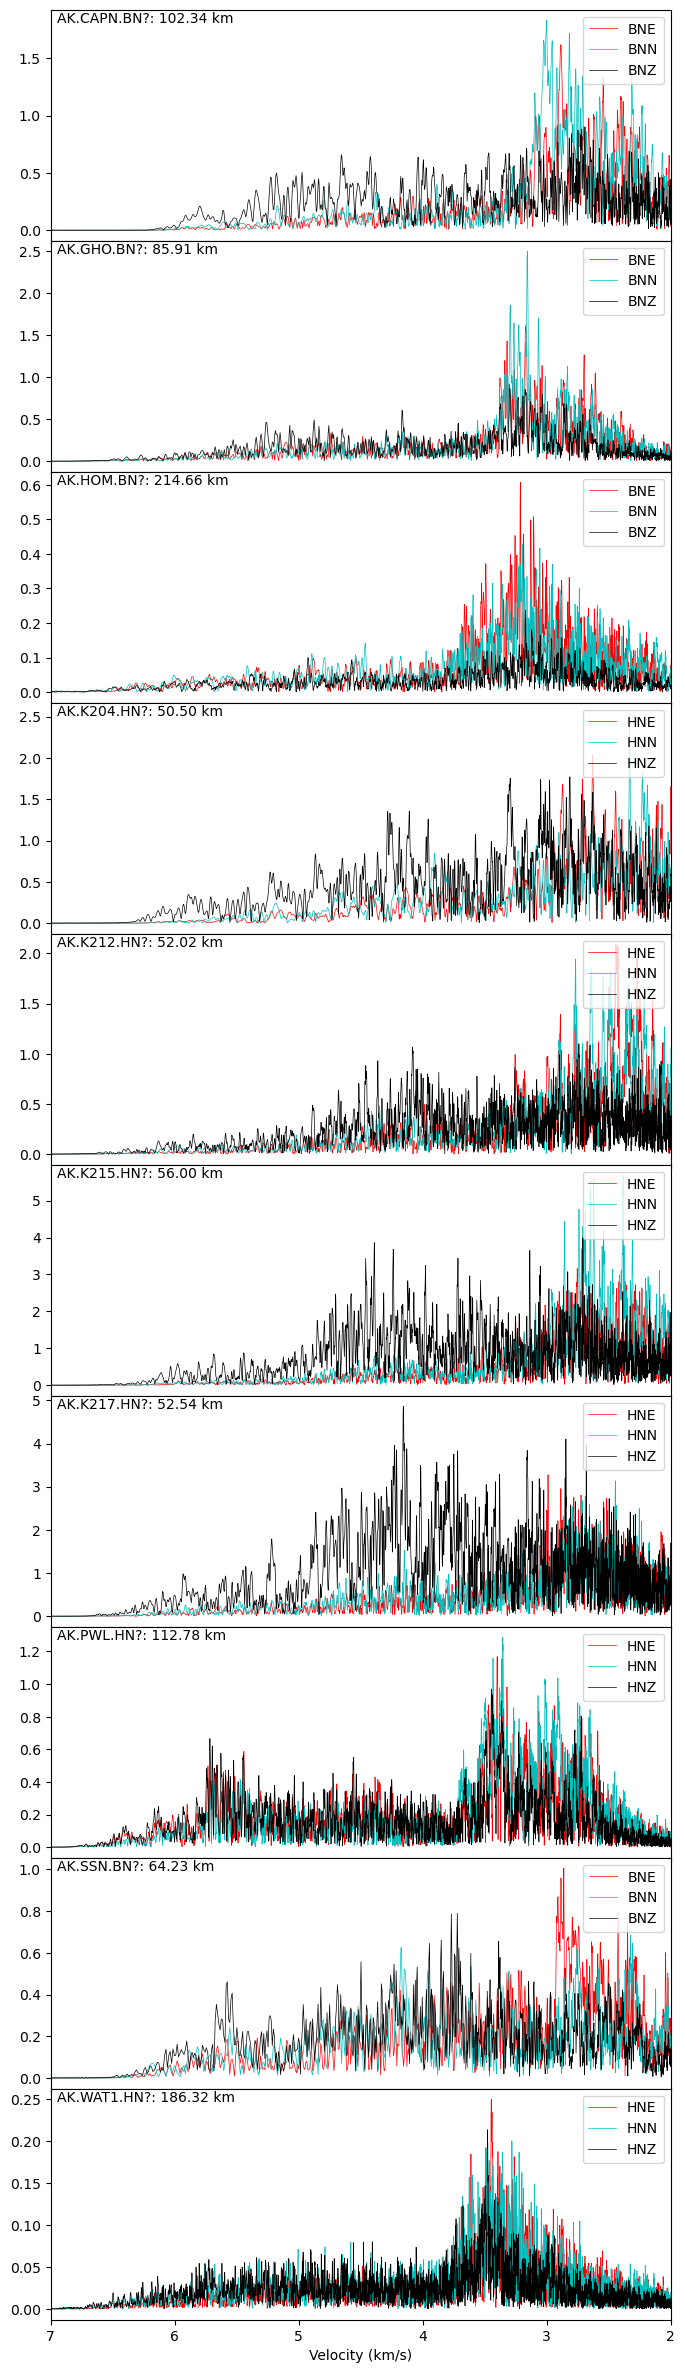

In [139]:
n_tr = len(st)
print('Number of traces:', n_tr)
alpha = 1
lw = 0.5

# st1 = st.copy()
# for i in len(st1):
#     tr = st1[i]
#     sample_rate = tr.stats.sampling_rate
    
    
st1.attach_response(inv)
st1 = st1.remove_response(output='ACC')

fig, ax = plt.subplots(nrows=n_tr // 3, sharex=True, figsize=(8,n_tr))
fig.subplots_adjust(hspace=0)
for i in range(n_tr // 3):
    sample = st[i*3].stats.channel[0]
    chan = sample + channel[1:]

    code = st1[i*3].stats.station
    net = st1[i*3].stats.network
    distance = station_data[code]['hypo_dist']
    
    tr_e = st1[i*3].detrend('demean')
    tr_n = st1[i*3 + 1].detrend('demean')
    tr_z = st1[i*3 + 2].detrend('demean')
    
    # tr_e = st1[i*3].detrend('demean')
    # tr_n = st1[i*3 + 1].detrend('demean')
    # tr_z = st1[i*3 + 2].detrend('demean')
    
    v_app_e = distance/tr_e.times()[1:]
    v_app_n = distance/tr_n.times()[1:]
    v_app_z = distance/tr_z.times()[1:]

    ax[i].plot(v_app_e, envelope(tr_e.data[1:]), c='r', label=tr_e.stats.channel, lw=lw, alpha=alpha)
    ax[i].plot(v_app_n, envelope(tr_n.data[1:]), c='c', label=tr_n.stats.channel, lw=lw, alpha=alpha)
    ax[i].plot(v_app_z, envelope(tr_z.data[1:]), c='k', label=tr_z.stats.channel, lw=lw, alpha=alpha)    

    ax[i].text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].legend(loc='upper right')
    # ax[i].set_title('%s: %.2f km' % (code, distance))
# plt.xscale('log')
plt.xlim(7, 2)
plt.xlabel('Velocity (km/s)')


In [ ]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,10))
for i in range(4):
    code = st1[i].stats.station
    distance = station_data[code]['hypo_dist']
    v_app = distance/st1[i].times()[1:]
    ax[i].plot(st1[i].times(), envelope(st[i].data), c='k')
    ax[i].text(0, np.max(st[i].data[1:])-1000, '%s: %.2f km' % (code, distance), va='top')

In [138]:
st[0].stats.sampling_rate

50.0

In [ ]:
len(st)

In [ ]:
plt.figure()
plt.plot(st1[0].times(), envelope(st1[0].data))

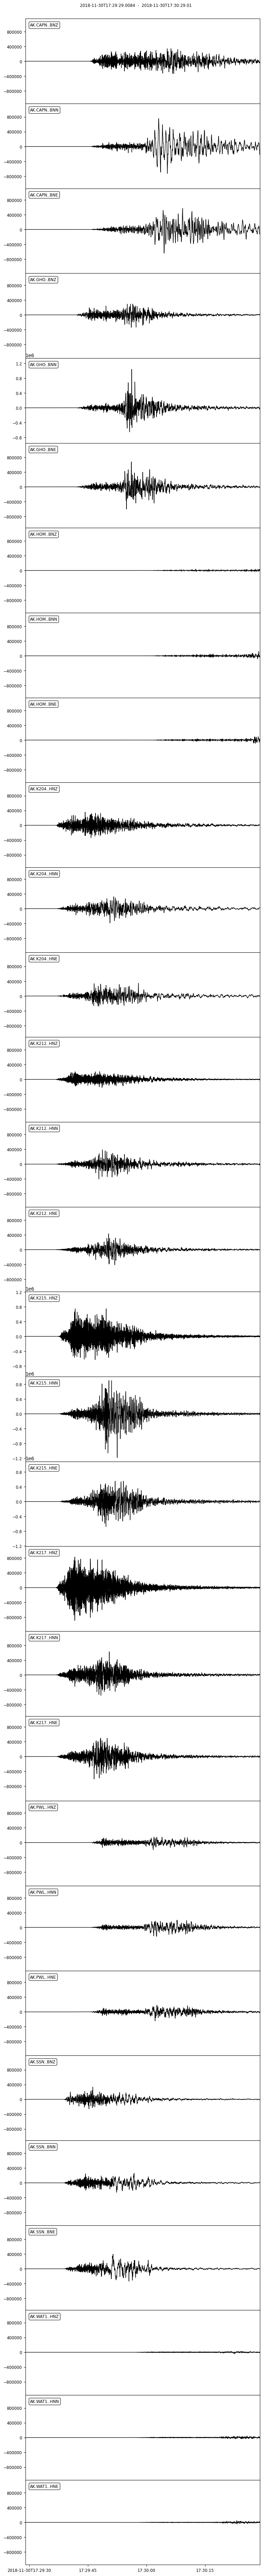

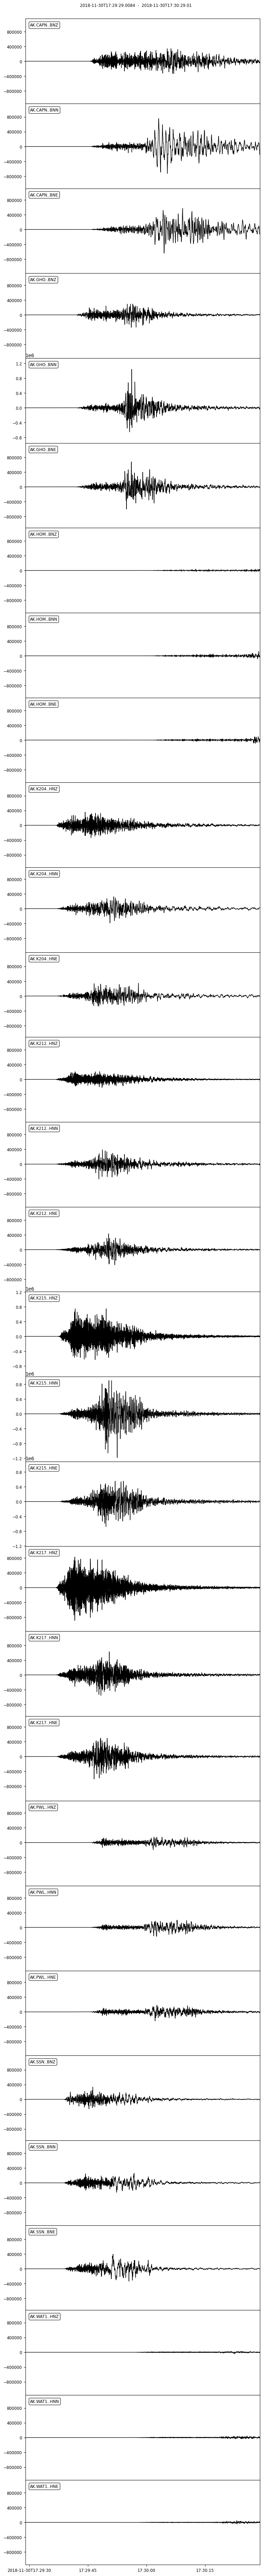

In [129]:
stt = st1.copy()
stt.trim(starttime=starttime+0, endtime=starttime+60)
stt.plot()

In [ ]:
stt = st.copy()
stt.trim(starttime=starttime, endtime=endtime)

for i in range(len(stt)//3):
    plt.figure()
    # st[i].plot()
    code = stt[i*3].stats.station
    net = stt[i*3].stats.network
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    plt.plot(stt[i*3].times(), stt[i*3].data, c='r', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+1].times(), stt[i*3+1].data, c='c', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+2].times(), stt[i*3+2].data, c='k', label=stt[i*3].stats.channel)

    # plt.text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=plt.transAxes)
    plt.legend(loc='upper right')

In [ ]:
st[0*3+1].times())

In [ ]:
st.plot()

In [29]:
stime = UTCDateTime('2018-11-30T17:29:29.000Z')
st = client.get_waveforms('AK', 'K223', '?', 'BN?', starttime=starttime, endtime=endtime)


2002-11-03T22:12:41.000000Z ~~~ 2002-11-03T22:12:51.000000Z


FDSNNoDataException: No data available for request.
HTTP Status code: 204
Detailed response of server:

